> * # 注意事项
添加数据集:

rsna-train-stage-1-images-png-224x/stage_1_train_png_224x

rsna-test-stage-1-images-png-224x/stage_1_test_png_224x


# Introduction

This is a simple fork of my previous kernel (https://www.kaggle.com/taindow/pytorch-efficientnet-b0), 
except here we make use of ResNeXt and "weakly supervised pre-training" as opposed to EfficientNet. 
See https://github.com/facebookresearch/WSL-Images for model information. 
Note due to the number of parameters a single sweep of the data will take approx. 4-5h.

# Sources

Windowing functions for pre-processed data taken from the following:

- https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing 

# Parameters

In [4]:
# Input

dir_csv = '../input/rsna-intracranial-hemorrhage-detection'
dir_train_img = '../input/rsna-train-stage-1-images-png-224x/stage_1_train_png_224x'
dir_test_img = '../input/rsna-test-stage-1-images-png-224x/stage_1_test_png_224x'


In [5]:
# Parameters
n_classes = 6
n_epochs = 10
batch_size = 64


# Setup

Need to grab a couple of extra libraries

- Nvidia Apex for mixed precision training (https://github.com/NVIDIA/apex)

In [3]:
%%time
# Installing useful libraries
!git clone https://github.com/NVIDIA/apex && cd apex && pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

Cloning into 'apex'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 5526 (delta 41), reused 36 (delta 7), pack-reused 5422
Receiving objects: 100% (5526/5526), 13.46 MiB | 0 bytes/s, done.
Resolving deltas: 100% (3552/3552), done.
/opt/conda/lib/python3.6/site-packages/pip/_internal/commands/install.py:243: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-4nvzd9by
Created temporary directory: /tmp/pip-req-tracker-nauan2ca
Created requirements tracker '/tmp/pip-req-tracker-nauan2ca'
Created temporary directory: /tmp/pip-install-92_aeaos
Processing /kaggle/working/apex
  Created temporary directory: /tmp/pip-req-build-lob1now0
  Added file:///kaggle/working/apex to build tracker '/tmp/pip-req-tracker-nauan2ca'
    R

    building 'apex_C' extension
    creating build/temp.linux-x86_64-3.6
    creating build/temp.linux-x86_64-3.6/csrc
    gcc -pthread -B /opt/conda/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/opt/conda/lib/python3.6/site-packages/torch/include -I/opt/conda/lib/python3.6/site-packages/torch/include/torch/csrc/api/include -I/opt/conda/lib/python3.6/site-packages/torch/include/TH -I/opt/conda/lib/python3.6/site-packages/torch/include/THC -I/opt/conda/include/python3.6m -c csrc/flatten_unflatten.cpp -o build/temp.linux-x86_64-3.6/csrc/flatten_unflatten.o -DTORCH_API_INCLUDE_EXTENSION_H -DTORCH_EXTENSION_NAME=apex_C -D_GLIBCXX_USE_CXX11_ABI=0 -std=c++11
    cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
    g++ -pthread -shared -B /opt/conda/compiler_compat -L/opt/conda/lib -Wl,-rpath=/opt/conda/lib -Wl,--no-as-needed -Wl,--sysroot=/ build/temp.linux-x86_64-3.6/csrc/flatten_unfla

    g++ -pthread -shared -B /opt/conda/compiler_compat -L/opt/conda/lib -Wl,-rpath=/opt/conda/lib -Wl,--no-as-needed -Wl,--sysroot=/ build/temp.linux-x86_64-3.6/csrc/amp_C_frontend.o build/temp.linux-x86_64-3.6/csrc/multi_tensor_sgd_kernel.o build/temp.linux-x86_64-3.6/csrc/multi_tensor_scale_kernel.o build/temp.linux-x86_64-3.6/csrc/multi_tensor_axpby_kernel.o build/temp.linux-x86_64-3.6/csrc/multi_tensor_l2norm_kernel.o build/temp.linux-x86_64-3.6/csrc/multi_tensor_lamb_stage_1.o build/temp.linux-x86_64-3.6/csrc/multi_tensor_lamb_stage_2.o build/temp.linux-x86_64-3.6/csrc/multi_tensor_adam.o build/temp.linux-x86_64-3.6/csrc/multi_tensor_novograd.o build/temp.linux-x86_64-3.6/csrc/multi_tensor_lamb.o -L/usr/local/cuda/lib64 -lcudart -o build/lib.linux-x86_64-3.6/amp_C.cpython-36m-x86_64-linux-gnu.so
    building 'syncbn' extension
    gcc -pthread -B /opt/conda/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/opt/conda/lib/pytho

    byte-compiling /opt/conda/lib/python3.6/site-packages/apex/normalization/__init__.py to __init__.cpython-36.pyc
    byte-compiling /opt/conda/lib/python3.6/site-packages/apex/normalization/fused_layer_norm.py to fused_layer_norm.cpython-36.pyc
    byte-compiling /opt/conda/lib/python3.6/site-packages/apex/contrib/xentropy/softmax_xentropy.py to softmax_xentropy.cpython-36.pyc
    byte-compiling /opt/conda/lib/python3.6/site-packages/apex/contrib/xentropy/__init__.py to __init__.cpython-36.pyc
    byte-compiling /opt/conda/lib/python3.6/site-packages/apex/contrib/groupbn/batch_norm.py to batch_norm.cpython-36.pyc
    byte-compiling /opt/conda/lib/python3.6/site-packages/apex/contrib/groupbn/__init__.py to __init__.cpython-36.pyc
    byte-compiling /opt/conda/lib/python3.6/site-packages/apex/contrib/__init__.py to __init__.cpython-36.pyc
    byte-compiling /opt/conda/lib/python3.6/site-packages/apex/contrib/optimizers/fp16_optimizer.py to fp16_optimizer.cpython-36.pyc
    byte-compil

    running egg_info
    creating apex.egg-info
    writing apex.egg-info/PKG-INFO
    writing dependency_links to apex.egg-info/dependency_links.txt
    writing top-level names to apex.egg-info/top_level.txt
    writing manifest file 'apex.egg-info/SOURCES.txt'
    writing manifest file 'apex.egg-info/SOURCES.txt'
    Copying apex.egg-info to /opt/conda/lib/python3.6/site-packages/apex-0.1-py3.6.egg-info
    running install_scripts
    writing list of installed files to '/tmp/pip-record-qn8z1g6q/install-record.txt'
  Running setup.py install for apex ... done
  Removing source in /tmp/pip-req-build-lob1now0
Cleaning up...
Removed build tracker '/tmp/pip-req-tracker-nauan2ca'
1 location(s) to search for versions of pip:
* https://pypi.org/simple/pip/
Getting page https://pypi.org/simple/pip/
Found index url https://pypi.org/simple
Getting credentials from keyring for https://pypi.org/simple
Getting credentials from keyring for pypi.org
Starting new HTTPS connection (1): pypi.org:443
ht

  Found link https://files.pythonhosted.org/packages/67/f0/ba0fb41dbdbfc4aa3e0c16b40269aca6b9e3d59cacdb646218aa2e9b1d2c/pip-6.1.1-py2.py3-none-any.whl#sha256=a67e54aa0f26b6d62ccec5cc6735eff205dd0fed075f56ac3d3111e91e4467fc (from https://pypi.org/simple/pip/), version: 6.1.1
  Found link https://files.pythonhosted.org/packages/bf/85/871c126b50b8ee0b9819e8a63b614aedd264577e73478caedcd447e8f28c/pip-6.1.1.tar.gz#sha256=89f3b626d225e08e7f20d85044afa40f612eb3284484169813dc2d0631f2a556 (from https://pypi.org/simple/pip/), version: 6.1.1
  Found link https://files.pythonhosted.org/packages/5a/9b/56d3c18d0784d5f2bbd446ea2dc7ffa7476c35e3dc223741d20cfee3b185/pip-7.0.0-py2.py3-none-any.whl#sha256=309c48399c7d68501a10ef206abd6e5c541fedbf84b95435d9063bd454b39df7 (from https://pypi.org/simple/pip/), version: 7.0.0
  Found link https://files.pythonhosted.org/packages/c6/16/6475b142927ca5d03e3b7968efa5b0edd103e4684ecfde181a25f6fa2505/pip-7.0.0.tar.gz#sha256=7b46bfc1b95494731de306a688e2a7bc056d7fa7ad27e

CPU times: user 2.62 s, sys: 644 ms, total: 3.26 s
Wall time: 2min 52s


In [ ]:
!ls -l

In [ ]:
!cd /kaggle/input;ls -l

In [21]:
%%time
# Libraries

from apex import amp
import os
import cv2
import glob
import pydicom
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
# from albumentations import Compose, ShiftScaleRotate, Resize, CenterCrop, HorizontalFlip, RandomBrightnessContrast

from torch.utils.data import Dataset
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from torchvision import transforms
import torchvision

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 62.2 µs


# CSV

In [22]:
%%time
# CSVs

train = pd.read_csv(os.path.join(dir_csv, 'stage_1_train.csv'))
train=train.sample(frac=1).reset_index(drop=True)#shuffle操作 

test = pd.read_csv(os.path.join(dir_csv, 'stage_1_sample_submission.csv'))

CPU times: user 4.62 s, sys: 212 ms, total: 4.84 s
Wall time: 4.84 s


In [8]:
%%time
# CPU times: user 31.5 s, sys: 1.12 s, total: 32.6 s
# Wall time: 32.6 s

# Split train out into row per image and save a sample

train[['ID', 'Image', 'Diagnosis']] = train['ID'].str.split('_', expand=True)
train = train[['Image', 'Diagnosis', 'Label']]
train.drop_duplicates(inplace=True)
train = train.pivot(index='Image', columns='Diagnosis', values='Label').reset_index()
train['Image'] = 'ID_' + train['Image']
train.head()

CPU times: user 39.1 s, sys: 1.72 s, total: 40.8 s
Wall time: 40.9 s


Diagnosis,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000039fa0,0,0,0,0,0,0
1,ID_00005679d,0,0,0,0,0,0
2,ID_00008ce3c,0,0,0,0,0,0
3,ID_0000950d7,0,0,0,0,0,0
4,ID_0000aee4b,0,0,0,0,0,0


In [9]:
%%time
undersample_seed=0
train["any"].value_counts()

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 10.8 ms


0    577155
1     97103
Name: any, dtype: int64

In [10]:
%%time
num_ill_patients = train[train["any"]==1].shape[0]
num_ill_patients

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 19.8 ms


97103

In [16]:
healthy_patients = train[train["any"]==0].index.values
healthy_patients_selection = np.random.RandomState(undersample_seed).choice(
    healthy_patients, size=num_ill_patients, replace=False
)
len(healthy_patients_selection)

97103

In [17]:
sick_patients = train[train["any"]==1].index.values
selected_patients = list(set(healthy_patients_selection).union(set(sick_patients)))
len(selected_patients)/2

96914.0

In [13]:
new_train = train.loc[selected_patients].copy()
new_train["any"].value_counts()

1    97103
0    97103
Name: any, dtype: int64

In [18]:
%%time

# CPU times: user 12.6 s, sys: 1.11 s, total: 13.7 s
# Wall time: 18.5 s
# Some files didn't contain legitimate images, so we need to remove them

png = glob.glob(os.path.join(dir_train_img, '*.png'))
png = [os.path.basename(png)[:-4] for png in png]
png = np.array(png)

train = train[train['Image'].isin(png)]
train.to_csv('train.csv', index=False)

CPU times: user 11 s, sys: 860 ms, total: 11.9 s
Wall time: 11.9 s


In [23]:
%%time
# Also prepare the test data

test[['ID','Image','Diagnosis']] = test['ID'].str.split('_', expand=True)
test['Image'] = 'ID_' + test['Image']
test = test[['Image', 'Label']]
test.drop_duplicates(inplace=True)

test.to_csv('test.csv', index=False)

CPU times: user 3.96 s, sys: 20 ms, total: 3.98 s
Wall time: 3.98 s


# DataLoaders

In [24]:
%%time
# Functions

from PIL import Image

class IntracranialDataset(Dataset):

    def __init__(self, csv_file, path, labels, transform=None):
        
        self.path = path
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.labels = labels

    def __len__(self):
        
        return len(self.data)

    def __getitem__(self, idx):
#         print("***********************")
        #idx??????
#         print("得到的數據＝",self.data)
#         print("數據類型＝",type(self.data))
#         print("idx=",idx)
#         print("self.data.loc[idx, 'Image']=",self.data.loc[idx, 'Image'])
#         print("-----------------监测点1------------------------")
#         print("-----------------------------")
        
        img_name = os.path.join(self.path, self.data.loc[idx, 'Image'] + '.png')
#         print("-----------------监测点2------------------------")
#         根据idx变量获得一个ｐｎｇ文件的完整路径+文件名

#         img_name = os.path.join(self.path, self.data[['Image']]+ '.png')
#         print("img_name=",img_name)
        img = cv2.imread(img_name)   
#         print("img=",img)
#         print("***********************")
        if self.transform:       #进行数据强化
#             print("***********************")
#             augmented = self.transform(image=img)#??????????????
            augmented=self.transform(Image.fromarray(img))
            img=augmented
#             print("**********4*************")
#             print("__getitem__得到的數據類型",type(augmented))
#             img = augmented['image']   
        
#         print("-----------------看下要返回的东西的类型和内容------------------------------------")
#         print("type(img)=",type(img))
#         print("img=",img)
#         print("type(labels)=",type(self.labels))
#         print("labels=",self.labels)
        if self.labels:#训练集的类别标签
#             print("------这里应该进不来------")
            
            labels = torch.tensor(
                self.data.loc[idx, ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']])
            return {'image': img, 'labels': labels}    
        
        else:      
#             print("_------------------是走这里的吗--------------------------")
#             augmented=self.transform(Image.fromarray(img))
#             augmentedself.transform(Image.fromarray(img))
#             img=augmented
            
            return {'image': img}#用于测试数据的读取
    
    


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 108 µs


In [26]:
%%time
from torchvision import transforms
# Data loaders
#－－－－－－－－－－－－－－－－－－－－－下面是训练集加载－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomRotation(degrees = 10),
    transforms.ToTensor(),
])
# 上面的这个东西看起来有点像是管道

train_dataset = IntracranialDataset(csv_file='train.csv', path=dir_train_img, transform=transform_train, labels=True)
#csv_file:图片数据的类别标签
#dir_train_img:图片数据
data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
#－－－－－－－－－－－－－－－－－－－－－－下面是测试集加载－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－

transform_test= transforms.Compose([
#     CenterCrop(200, 200),
                         #Resize(224, 224),
    transforms.ToTensor(),
])


test_dataset = IntracranialDataset(csv_file='test.csv', path=dir_test_img, transform=transform_test, labels=False)
data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

CPU times: user 592 ms, sys: 8 ms, total: 600 ms
Wall time: 599 ms


CPU times: user 76 ms, sys: 124 ms, total: 200 ms
Wall time: 2.09 s


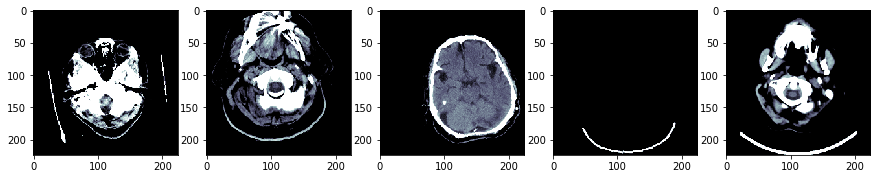

In [27]:
%%time
# 绘制一些训练图片

batch = next(iter(data_loader_train))
fig, axs = plt.subplots(1, 5, figsize=(15,5))

for i in np.arange(5):
    
    axs[i].imshow(np.transpose(batch['image'][i].numpy(), (1,2,0))[:,:,0], cmap=plt.cm.bone)


CPU times: user 64 ms, sys: 136 ms, total: 200 ms
Wall time: 1.35 s


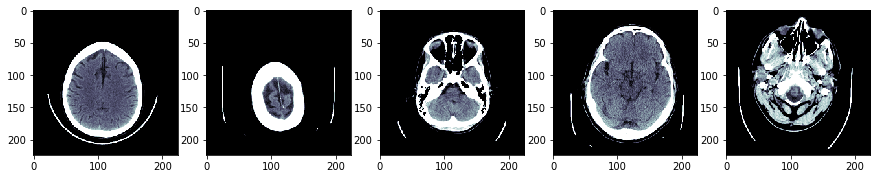

In [28]:
%%time
# 绘制一些测试图片
batch = next(iter(data_loader_test))
fig, axs = plt.subplots(1, 5, figsize=(15,5))

for i in np.arange(5):
    
    axs[i].imshow(np.transpose(batch['image'][i].numpy(), (1,2,0))[:,:,0], cmap=plt.cm.bone)


# Model

In [29]:
# Model
import torchvision.models as models
model = models.vgg19(pretrained=True)
print("--------------------模型修改前-------------------------------------")

device = torch.device("cuda:0")
# model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
# print(model.eval())
# https://github.com/facebookresearch/WSL-Images
# 上面这种加载方式只支持四种模型
print("----------------------模型修改后----------------------------------")
model.classifier.fc = torch.nn.Linear(1000, n_classes)

model.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /tmp/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 90.9MB/s] 


--------------------模型修改前-------------------------------------
----------------------模型修改后----------------------------------


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [30]:
criterion = torch.nn.BCEWithLogitsLoss(weight=torch.Tensor([2/7,1/7,1/7,1/7,1/7,1/7]).cuda())
plist = [{'params': model.parameters(), 'lr': 2e-5}]
optimizer = optim.SGD(plist, lr=2e-5)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,base_lr=0.01,cycle_momentum=True,max_lr=0.09)

model, optimizer = amp.initialize(model, optimizer, opt_level="O1")


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


# Training（训练一次就导出权重文件）
# 为了防止kernel中途卡死，每次epoch结束后的model文件必须导出！！！

# Training－1st epoch（水平翻转概率＝1）

In [ ]:
print("------------------")

In [ ]:
!    ls

In [ ]:
# Train

# 参考下这个代码
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

# 周期性学习率代码:
# https://pytorch.org/docs/stable/optim.html

model.train()    
tr_loss = 0 
tk0 = tqdm(data_loader_train, desc="Iteration")
for step, batch in enumerate(tk0):
    inputs = batch["image"]
    labels = batch["labels"]
    
    inputs = inputs.to(device, dtype=torch.float)
    labels = labels.to(device, dtype=torch.float)

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    with amp.scale_loss(loss, optimizer) as scaled_loss:
        scaled_loss.backward()

    tr_loss += loss.item()

    optimizer.step()
    optimizer.zero_grad()
        
    if step > 6000:
        epoch_loss = tr_loss / 6000
        print('Training Loss: {:.4f}'.format(epoch_loss))
        break

epoch_loss = tr_loss / len(data_loader_train)
print('Training Loss: {:.4f}'.format(epoch_loss))
scheduler.step()

In [ ]:
model_name='model-1st.pkl'
torch.save(model, model_name)
# 加载整个模型 
model = torch.load(model_name)
from IPython.display import FileLink
FileLink(model_name)#导出权重文件

# Inference-1st epoch

In [ ]:
# Inference

for param in model.parameters():
    param.requires_grad = False

model.eval()

test_pred = np.zeros((len(test_dataset) * n_classes, 1))

for i, x_batch in enumerate(tqdm(data_loader_test)):
    
    x_batch = x_batch["image"]
    x_batch = x_batch.to(device, dtype=torch.float)
    
    with torch.no_grad():
        
        pred = model(x_batch)
        
        test_pred[(i * batch_size * n_classes):((i + 1) * batch_size * n_classes)] = torch.sigmoid(
            pred).detach().cpu().reshape((len(x_batch) * n_classes, 1))

# Submission-1st epoch

In [ ]:
# Submission

submission =  pd.read_csv(os.path.join(dir_csv, 'stage_1_sample_submission.csv'))
submission = pd.concat([submission.drop(columns=['Label']), pd.DataFrame(test_pred)], axis=1)
submission.columns = ['ID', 'Label']

submission.to_csv('submission.csv', index=False)
submission.head()

# Clean Up

Have to clean up since Kaggle limits the number of files that can be output from a kernel

In [ ]:
!rm -rf /kaggle/working/apex
!rm test.csv
!rm train.csv